In [ ]:
# Load Dependencies
import os
import numpy as np
from skimage.io import imread, imshow
from collections import Counter
import subprocess 
from subprocess import PIPE
from skimage.io import imread, imshow, imsave
from itertools import product
from skimage.filters import threshold_otsu

import cv2
import pandas as pd
from scipy import ndimage as nd
from matplotlib import pyplot as plt
import glob

In [ ]:
def otsu_threshold (img):
  # return the number of threshold
  # np.where to binarize the image given the threshold.
  thresh = threshold_otsu(img)
  # make all pixels < threshold black
  binarized = 1.0 * (img > thresh)

  return binarized.astype(int)

In [ ]:
# Create a list of names from masks including at least one cloudy pixel, with the scope not including them in our analysis.
source_path = os.getcwd() + '/LabelHand/'
listimages=[]
alllist = []
for item in os.listdir(source_path):
    print(item)
    img = imread(source_path+item)
    alllist.append(item)
    countminus = np.count_nonzero(img ==-1)    
    if countminus==0: 
      x = item.split("_")
      name = x[0] +"_"+ x[1]+"_"+x[3]
      listimages.append(name)

In [ ]:
# Create two new list which host only the images without clouds.
folders = ["S2Hand","LabelHand"]
S2List = []
LabeList =[]

for folder in folders:
    source_path = os.getcwd() + '/' + folder +'/'
    for item in os.listdir(source_path):
        x = item.split("_")
        name = x[0] +"_"+ x[1]+"_"+x[3]
        if name in listimages:
            # path = os.path.join(source_path, item)
            # print(item)
            if folder == "S2Hand":
              S2List.append(item)
            else:
              LabeList.append(item)

In [ ]:
source_paths = "S2Hand/"
label_path = "LabelHand/"

## Sanity Check
S2List = sorted(S2List)
LabeList = sorted(LabeList)
print(len(S2List))
print(len(LabeList))

print(f"The first image:", S2List[0])
print(f"The first image:", LabeList[0])

337
337
The first image: Bolivia_103757_S2Hand_384256384512.tif
The label image: Bolivia_103757_LabelHand_384256384512.tif


In [ ]:
####################################################################
## STEP 1:   READ TRAINING IMAGES AND EXTRACT FEATURES  - Sentinel 1
################################################################
image_dataset_s1 = pd.DataFrame()  #Dataframe to capture image features

img_path = "S2Hand/" ## CHANGE ME!!!
for image in S2List:
  df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
  
  green = imread(img_path + image)[1:2,:,:].reshape((128,128))
  swir = imread(img_path + image)[4:5,:,:].reshape((128,128))

# Sentinel-2 MNDWI = (B03 - B08) / (B03 + B08)
  ndwi = (green - swir)/ (green + swir)
  binaryimage = otsu_threshold(ndwi)  
  ndwi_values = binaryimage.reshape(-1)
  df['Predicted'] = ndwi_values  

  ######################################                    
  #Update dataframe for images to include details for each image in the loop
  image_dataset_s1 = image_dataset_s1.append(df)

In [ ]:
###########################################################
# STEP 2: READ LABELED IMAGES (MASKS) AND CREATE ANOTHER DATAFRAME
    # WITH LABEL VALUES AND LABEL FILE NAMES
##########################################################
mask_dataset = pd.DataFrame()  #Create dataframe to capture mask info.

mask_path = "LabelHand/" ### CHANGE ME!!!
for mask in LabeList:   #os.listdir(mask_path):
    df2 = pd.DataFrame()  #Temporary dataframe to capture info for each mask in the loop
    input_mask = imread(mask_path + mask)
    label = input_mask
    #Add pixel values to the data frame
    label_values = label.reshape(-1)
    df2['Label_Value'] = label_values
    df2['Mask_Name'] = mask
    mask_dataset = mask_dataset.append(df2)  #Update mask dataframe with all the info from each mask

In [ ]:
# Sanity Check 
print(len(mask_dataset.Mask_Name))
print(len(image_dataset_s1.Predicted))

5521408

In [ ]:
 #Concatenate both image and mask datasets
dataset = pd.concat([image_dataset_s1, mask_dataset], axis=1)   

# Drop NA
dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [ ]:
# Transform label and predicted values into vectors.
y_true = dataset.Label_Value.values
y_pred = dataset.Predicted.values

In [ ]:
# Print Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred, normalize=True)
print(acc)

0.8140709760988502


In [ ]:
# Print F1 Score
from sklearn.metrics import f1_score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')

print("F1 macro", f1_macro)
print("F1 micro", f1_micro)

F1 macro 0.8118777041639389
F1 micro 0.8140709760988503


In [ ]:
# Print IoU 
from sklearn.metrics import jaccard_score
iou = jaccard_score(y_true, y_pred)
print(iou)

0.6550332503335115


In [ ]:
# Print Recall 
from sklearn.metrics import recall_score
recal1 = recall_score(y_true, y_pred, average='macro')
recal2 = recall_score(y_true, y_pred, average='micro')
print(recal1, recal2)

0.8343929280036686 0.8140709760988502


In [ ]:
# Print Precision score
from sklearn.metrics import precision_score
pre1 = precision_score(y_true, y_pred, average='macro')
pre2 = precision_score(y_true, y_pred, average='micro')
print(pre1, pre2)

#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
#'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

0.816237197939323 0.8140709760988502


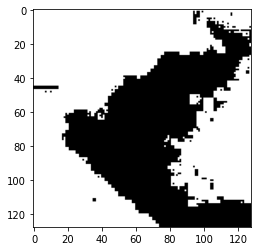

In [ ]:
## Plot an example of predicted image
source_paths = "S2Hand/"
imagetobeviz = S2List[0] # plot the first image of the list


green = imread(source_paths + imagetobeviz)[1:2,:,:].reshape((128,128))
swir = imread(source_paths + imagetobeviz)[4:5,:,:].reshape((128,128))

# Sentinel-2 MNDWI2 = (B03 - B08) / (B03 + B08)
ndwi = (green - swir)/ (green + swir)
binaryimage = otsu_threshold(ndwi)  

plt.imshow(binaryimage, cmap='binary')


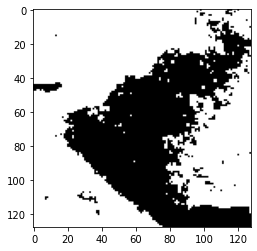

In [ ]:
# Print the Corresponding Ground Truth Image
label_path = "LabelHand/"

labeltobeviz = LabeList[0]

mask = imread(label_path + labeltobeviz)

plt.imshow(mask, cmap='binary')